In [5]:
# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

import datetime as dt

# Utilities
import boto3
import dateutil
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")    

In [6]:
# Initialize SentinelHubBYOC class
#https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.html


byoc = SentinelHubBYOC(config=config)
print ("START--------------------------")
# list collections and tiles
# from: https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
collections_iterator = byoc.iter_collections()
my_collections = list(collections_iterator)

for collection in my_collections:
    
    print("Collection name:", collection["name"])
    print("Collection id: ", collection["id"])
    tiles = list(byoc.iter_tiles(collection))
    for tile in tiles:
        print("Tile status: ", tile['status'])
        print("Tile created: ", tile['created'])
        print("Tile path: ", tile['path'])
        if(tile['status'] == "FAILED"):
            print("Ingestion failed error: ", tile['additionalData'])
    print("-------------------")
print ("end")

START--------------------------
Collection name: UrbanAtlas2018_10m_raster
Collection id:  bc4099db-f686-4e66-99a6-387a11eb2067
Tile status:  INGESTED
Tile created:  2023-03-01T10:20:07.219071Z
Tile path:  data/d002_urban_atlas_tiles2/ua2018_mosaic_raster_10m_cog_1_4_(BAND).tif
Tile status:  INGESTED
Tile created:  2023-03-01T10:20:07.004590Z
Tile path:  data/d002_urban_atlas_tiles2/ua2018_mosaic_raster_10m_cog_1_1_(BAND).tif
Tile status:  INGESTED
Tile created:  2023-03-01T10:20:07.364183Z
Tile path:  data/d002_urban_atlas_tiles2/ua2018_mosaic_raster_10m_cog_1_5_(BAND).tif
-------------------
end


In [7]:
# get first tile of first collection
collections_iterator = byoc.iter_collections()
collection = next(collections_iterator)
tile = next(byoc.iter_tiles(collection))
tile

{'id': '9561d1e7-f041-41b6-b790-8cc9c4bd0597',
 'created': '2023-03-01T10:20:07.219071Z',
 'ingestionStart': '2023-03-01T10:20:07.219071Z',
 'coverGeometry': {'type': 'Polygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::3035'}},
  'coordinates': [[[4273019.999997908, 4270229.999845818],
    [5273020.000042262, 4270229.99984135],
    [5273020.000041623, 5270229.999898263],
    [4273019.999997887, 5270229.999899021],
    [4273019.999997908, 4270229.999845818]]]},
 'tileGeometry': {'type': 'Polygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::3035'}},
  'coordinates': [[[4273020.0, 5270230.0],
    [5273020.0, 5270230.0],
    [5273020.0, 4270230.0],
    [4273020.0, 4270230.0],
    [4273020.0, 5270230.0]]]},
 'path': 'data/d002_urban_atlas_tiles2/ua2018_mosaic_raster_10m_cog_1_4_(BAND).tif',
 'status': 'INGESTED',
 'additionalData': {'hasAddedPoints': True,
  'filesMetadata': {'B1': {'headerSize': 104786,
    'etag': '"8561d73

In [8]:
### Lux extent box 6.20,49.60 : 6.34,49.66
## test area 2 17.968,  69.43 
##           : 20.376,  70.16 

#x1 = 6.2  # degree
#y1 = 49.60  # degree
#x2 = 6.34 # degree
#y2 = 49.66  # degree


x1 = 19.50  # degree
y1 = 69.43  # degree
x2 = 19.51 # degree
y2 = 69.44  # degree


bbox = x1, y1, x2, y2
aoi = BBox([x1, y1, x2, y2], crs=CRS.WGS84)
#spatial_res = 0.00018   # = 20.038 meters in degree

In [9]:
#https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
#https://eurodatacube.com/notebooks/contributions/LPIS_LULC-Slo.ipynb
data_collection = DataCollection.define_byoc(collection["id"])
data_collection

<DataCollection.BYOC_bc4099db-f686-4e66-99a6-387a11eb2067: DataCollectionDefinition(
  api_id: byoc-bc4099db-f686-4e66-99a6-387a11eb2067
  catalog_id: byoc-bc4099db-f686-4e66-99a6-387a11eb2067
  wfs_id: byoc-bc4099db-f686-4e66-99a6-387a11eb2067
  collection_type: BYOC
  collection_id: bc4099db-f686-4e66-99a6-387a11eb2067
  is_timeless: False
  has_cloud_coverage: False
)>

In [10]:
##https://docs.sentinel-hub.com/api/latest/evalscript/

#SentinelHubBaseApiRequest.input_data(data_collection, identifier, time_interval, maxcc, mosaicking_order, upsampling, downsampling, other_args)
###################################################
## what is the band name of the tile? 
## from documentation:  
## "bands are not defined before the tile ingestion process. 
## BYOC service then automatically configures bands based on the first ingested tile 
## and names the band after the filename unless a band placeholder is defined"
## -> in this case, if tile was ingested with path="folder/(BAND).tif" then band name is equal to filename "UrbanAtlas2018_lux"

evalscript_test = """

//VERSION=3
function setup() {
  return {
    input: ["B1"],
    output: { 
        bands: 1 ,
        sampleType: "UINT16" // raster format will be UINT16
        }
    
  };
}

function evaluatePixel(sample) {
  return [sample.B1];
}
"""

request = SentinelHubRequest(
        evalscript=evalscript_test,
        input_data=[
            SentinelHubRequest.input_data(
                #data_collection=data_collection,
                data_collection=data_collection,
                #time_interval=tile_time
                # time_interval="2018"
                
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=aoi,
        size=bbox_to_dimensions(aoi, 10),
        config=config
    )
data = request.get_data()[0]

In [11]:
data

array([[33000, 33000, 33000, ..., 33000, 33000, 33000],
       [33000, 33000, 33000, ..., 33000, 33000, 33000],
       [33000, 33000, 33000, ..., 33000, 33000, 33000],
       ...,
       [33000, 33000, 33000, ..., 32000, 32000, 32000],
       [33000, 33000, 33000, ..., 32000, 32000, 32000],
       [33000, 33000, 33000, ..., 23000, 23000, 23000]], dtype=int32)

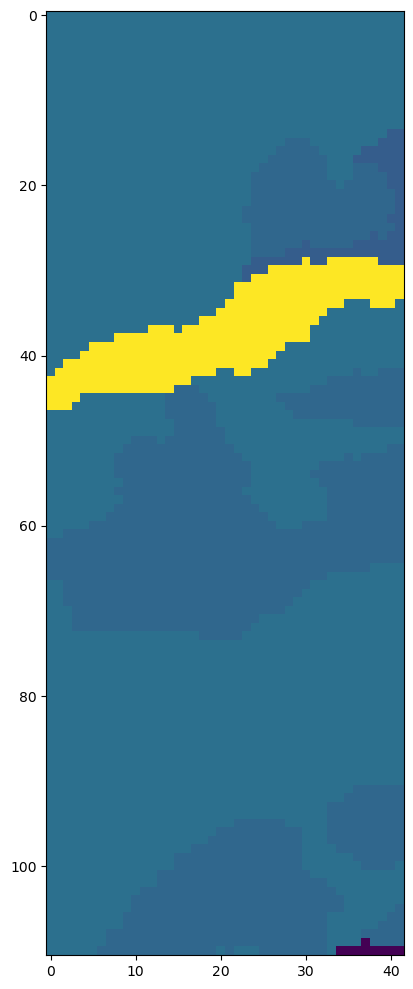

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(data)
# ax.set_title(tile_time.date().isoformat(), fontsize=10)

plt.tight_layout()

In [13]:
# show tile info in table format -- works for one tile
tile_iterator = byoc.iter_tiles(collection)
tiles_for_visualized = []
tiles_for_visualized.append(ByocTile.from_dict(next(tile_iterator)))

tiles_gdf = gpd.GeoDataFrame(
    tiles_for_visualized,
    geometry=[t.cover_geometry.transform(CRS.WGS84).geometry for t in tiles_for_visualized],
    crs="epsg:4326",
)
tiles_gdf

# show tile info in table format -- works for more than one tiles
# tile_iterator = byoc.iter_tiles(created_collection)
# tiles_for_visualized = []
# for i in range(100):
#     tiles_for_visualized.append(ByocTile.from_dict(next(tile_iterator)))

# tiles_gdf = gpd.GeoDataFrame(
#     tiles_for_visualized,
#     geometry=[t.cover_geometry.transform(CRS.WGS84).geometry for t in tiles_for_visualized],
#     crs="epsg:4326",
# )
# tiles_gdf.head()

,path,status,tile_id,tile_geometry,cover_geometry,created,sensing_time,additional_data,other_data,geometry
0,data/d002_urban_atlas_tiles2/ua2018_mosaic_ras...,INGESTED,9561d1e7-f041-41b6-b790-8cc9c4bd0597,"Geometry(POLYGON ((4273020 5270230, 5273020 52...",Geometry(POLYGON ((4273019.999997908 4270229.9...,2023-03-01 10:20:07.219071+00:00,None,"{'hasAddedPoints': True, 'filesMetadata': {'B1...",{'ingestionStart': '2023-03-01T10:20:07.219071Z'},"POLYGON ((9.10143 61.53031, 27.46433 60.46807,..."


In [ ]:
# show tile extent...
fig, ax = plt.subplots(figsize=(17, 8))
tiles_gdf.plot(ax=ax);